In [ ]:
!pip install huggingface_hub --upgrade

In [ ]:
!pip install torchmetrics\[detection\]

In [ ]:
!pip install transformers==4.26.0

In [ ]:
!pip install -U pytorch-lightning

In [ ]:
!pip install timm

In [ ]:
!pip install datasets


In [ ]:
import os
import re
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision
from torchvision.transforms import ToPILImage
import torch
from torch.utils.data import Dataset as PTD
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import CSVLogger
from transformers import DetrConfig, AutoModelForObjectDetection
from transformers import AutoFeatureExtractor
import datasets

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-tiny", do_resize=False, return_segmentation_masks=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Tran

In [ ]:
train_inds = [i for i in range(1,2)]
val_inds = [i for i in range(3,4)]
test_inds = [i for i in range(5,6)]

In [ ]:
print(train_inds)
print(val_inds)
print(test_inds)

[1]
[3]
[5]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH="/content/drive/My Drive/african-wildlife/Sample"
WIDTH=300
HEIGHT=200

In [ ]:
class animal_data(PTD):
    def __init__(self,inds,extractor=feature_extractor,path=PATH,height=HEIGHT,width=WIDTH):
        super().__init__()
        self.extractor=extractor
        self.inds=inds
        self.width=width
        self.height=height
        self.imgs=[]
        self.labels=[]
        self.path=path
        animals = os.listdir(self.path)
        to_fix={"zebra":[55,137,233,298],"buffalo":[286],"rhino":[70,107,114,147],"elephant":[322]}
        for an in animals:
            animal_path = os.path.join(self.path,an)
            for i in self.inds:
                if i in to_fix[an]:
                    ind = to_fix[an].index(i)+376
                else:
                    ind=i
                imgpath = os.path.join(animal_path,f"{ind:03}.jpg")
                labelpath = os.path.join(animal_path,f"{ind:03}.txt")
                self.imgs.append(imgpath)
                self.labels.append(labelpath)
    def __len__(self):
        return len(self.imgs)
    def get_sample(self,idx):
        print(idx)
        try:
            img = Image.open(self.imgs[idx]).resize((self.width,self.height))
        except:
            try:
                img = Image.open(self.imgs[idx].replace("jpg","JPG")).resize((self.width,self.height))
            except:
                print("sldkjf")
        objs = []
        with open(self.labels[idx]) as f:
            labels = f.read()
        labels = labels.split("\n")
        if "" in labels:
            labels.remove("")
        for i in range(len(labels)):
            labels[i] = labels[i].split(' ')
            clss = int(labels[i][0])
            bbox = labels[i][1:]
            for b in range(4):
                bbox[b] = float(bbox[b])
            bbox[0]*=self.width
            bbox[1]*=self.height
            bbox[2]*=self.width
            bbox[3]*=self.height
            bbox[0]-=bbox[2]/2
            bbox[1]-=bbox[3]/2
            objs.append({"bbox":bbox,"category_id":clss,"area":bbox[2]*bbox[3]*self.height*self.width})
        return img, objs, clss
    def __getitem__(self, idx):
        img, objs, clss = self.get_sample(idx)
        target = {"image_id":str(clss)+"_"+self.imgs[idx][-7:-4],"annotations":objs}
        encoding = self.extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]
        return pixel_values, target

In [ ]:
train_dataset=animal_data(train_inds)
dev_dataset=animal_data(val_inds)
test_dataset=animal_data(test_inds)

In [ ]:
print(len(train_dataset))
print(len(dev_dataset))
print(len(test_dataset))


4
4
4


In [ ]:
id2label = {0:"buffalo",1:"elephant",2:"rhino",3:"zebra"}

In [ ]:
label2id = {v:k for k,v in id2label.items()}
label2id

{'buffalo': 0, 'elephant': 1, 'rhino': 2, 'zebra': 3}

3


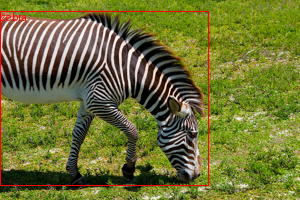

In [ ]:
image, annotations, clss = train_dataset.get_sample(3)
#annotations = fix(annotations)
draw = ImageDraw.Draw(image, "RGBA")
for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='red')
image

In [ ]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, collate_fn=collate_fn, batch_size=2)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=2)

In [ ]:
class Detr(pl.LightningModule):
    def __init__(self, lr=4e-05, weight_decay=1e-4, batch_size=16):
        super().__init__()
        # replace COCO classification head with custom head
        self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny",
                                                         num_labels=len(id2label),
                                                         ignore_mismatched_sizes=True)
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.weight_decay = weight_decay
        self.batch_size=batch_size
        self.factors = torch.tensor([595,841,595,841]).cuda()

    def forward(self, batch):
        outputs = self.model(pixel_values=batch["pixel_values"])
        return outputs

    def unprocess_boxes(self,bxz):
        for bks in bxz:
            bks*=self.factors
            bks[0]-=(bks[2]/2)
            bks[1]-=(bks[3]/2)
            bks[2]=bks[0]+bks[2]
            bks[3]=bks[1]+bks[3]
        return bxz

    def calcmetrics(self, outputs, batch):
        del batch["pixel_values"]
        target_sizes = torch.tensor([(841, 595)] * outputs.logits.shape[0]).cuda()
        ppp = feature_extractor.post_process_object_detection(
            outputs, threshold=0.5, target_sizes=target_sizes
        )
        f = []
        for i in range(len(batch["labels"])):
            f.append({
                "boxes": self.unprocess_boxes(batch["labels"][i]['boxes']),
                "labels": batch["labels"][i]["class_labels"]
            })
            batch["labels"][i] = 1
        del batch
        metric = MeanAveragePrecision(max_detection_thresholds=[10, 20, 50])  # Adjusted to three thresholds
        metric.update(ppp, f)
        return metric.compute()


    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss = outputs.loss
        loss_dict = outputs.loss_dict
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        res = self.calcmetrics(outputs,batch)
        for k,v in res.items():
            if k=="classes":
                continue
            self.log("train_" + k, v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss = outputs.loss
        loss_dict = outputs.loss_dict
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())
        res = self.calcmetrics(outputs,batch)
        for k,v in res.items():
            if k=="classes":
                continue
            self.log("validation_" + k, v.item())
        return loss

    def test_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss = outputs.loss
        loss_dict = outputs.loss_dict
        self.log("testing_loss", loss)
        for k,v in loss_dict.items():
            self.log("testing_" + k, v.item())
        res = self.calcmetrics(outputs,batch)
        for k,v in res.items():
            if k=="classes":
                continue
            self.log("testing_" + k, v.item())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=collate_fn, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dev_dataset, collate_fn=collate_fn, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(test_dataset, collate_fn=collate_fn, batch_size=self.batch_size)

In [ ]:
mymodel = Detr()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="validation_loss", mode="min")


In [ ]:
# !pip install wandb


In [ ]:
# from pytorch_lightning.loggers import WandbLogger

# wandb_logger = WandbLogger(project="wildlife-detection", name="yolos-tiny-training")
csv_logger = CSVLogger(save_dir="logs", name="animal_detection")



In [ ]:
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=2,  # Reduce epochs for faster training
    val_check_interval=0.5,
    log_every_n_steps=10,
    precision=16,
    logger=csv_logger,
    callbacks=[checkpoint_callback]
)


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
def show_model_outputs(idx=random.randint(0,len(test_dataset)-1)):
    idx=random.randint(0,len(dev_dataset)-1)
    img, objs, clss = test_dataset.get_sample(idx)
    pixel_values, target = test_dataset[idx]
    with torch.no_grad():
        outputs = mymodel.cpu()({"pixel_values":pixel_values.unsqueeze(0)})
    ppp = feature_extractor.post_process_object_detection(outputs,threshold=0.5,target_sizes=[(200,300)])
    ppp = ppp[0]

    draw = ImageDraw.Draw(img)

    for score, label, box in zip(ppp["scores"], ppp["labels"], ppp["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        x, y, x2, y2 = tuple(box)
        draw.rectangle((x, y, x2, y2), outline="red", width=1)
        draw.text((x, y-10), id2label[label.item()], fill="red")

    return img

In [ ]:
def test_unprocessing():
    idx=random.randint(0,len(dev_dataset)-1)
    img, objs, clss = dev_dataset.get_sample(idx)
    pixel_values, target = dev_dataset[idx]
    draw = ImageDraw.Draw(img)
    for i in range(len(target["boxes"])):
        box = target["boxes"][i]*torch.tensor([300,200,300,200])
        box[0]-=(box[2]/2)
        box[1]-=(box[3]/2)
        box[2]=box[0]+box[2]
        box[3]=box[1]+box[3]
        box = [round(i, 2) for i in box.tolist()]
        x, y, x2, y2 = tuple(box)
        label = target["class_labels"][i]
        draw.rectangle((x, y, x2, y2), outline="red", width=1)
        draw.text((x, y-10), id2label[label.item()], fill="red")
    return img


0
0


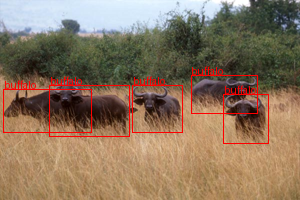

In [ ]:
test_unprocessing()


In [ ]:
trainer.fit(mymodel)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                    | Params | Mode
---------------------------------------------------------
0 | model | YolosForObjectDetection | 6.5 M  | eval
---------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.888    Total estimated model params size (MB)
0         Modules in train mode
236       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

0
1
2
3


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 50 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

1
2
3
0


Validation: |          | 0/? [00:00<?, ?it/s]

0
1
2
3
2
3
0
1


Validation: |          | 0/? [00:00<?, ?it/s]

0
1
2
3


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


2
2
0
0
2
2
3
3


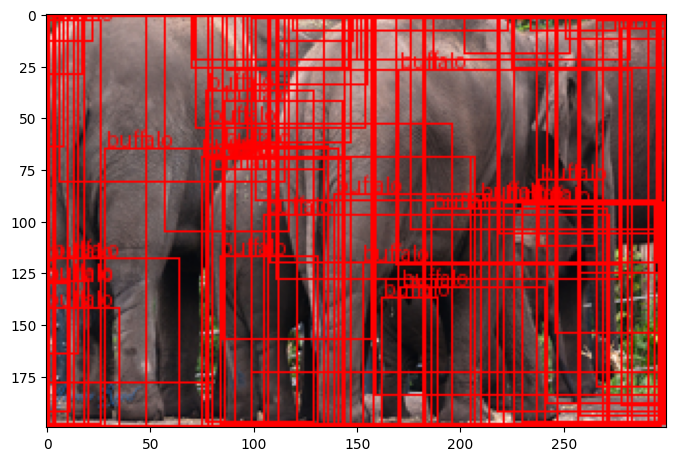

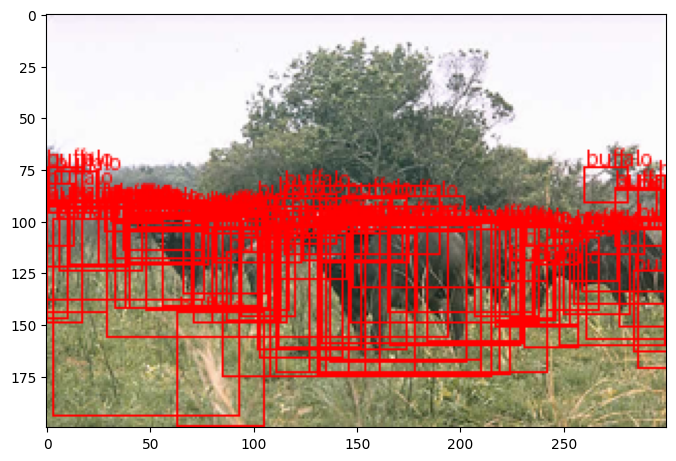

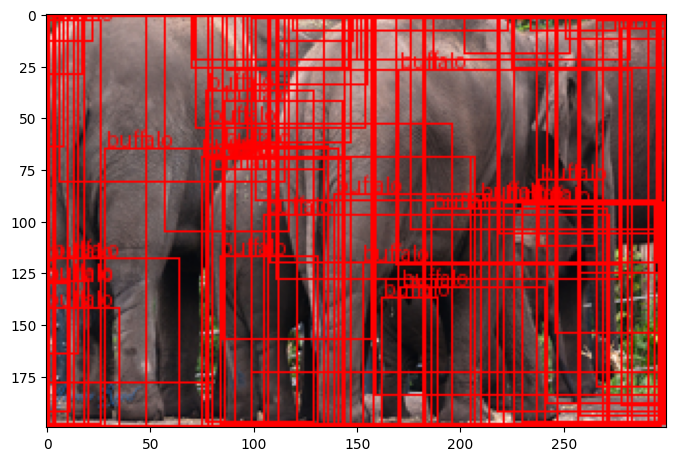

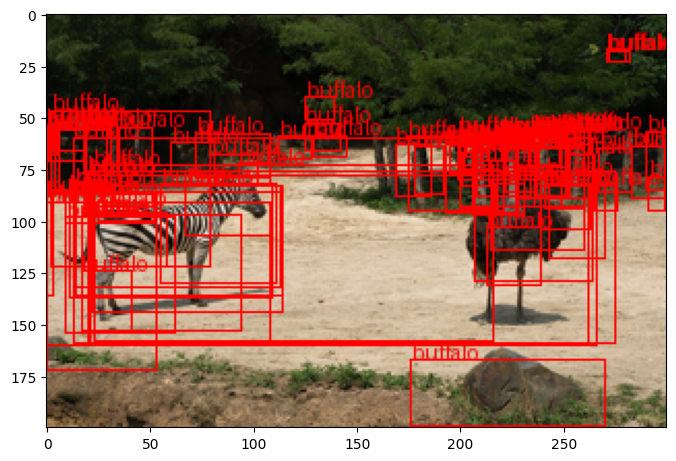

In [ ]:
for i in range(4):
    plt.figure(figsize=(8,12))
    img = np.array(show_model_outputs())
    plt.imshow(img)

In [ ]:
trainer.validate(mymodel)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

0
1
2
3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric        ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ validation_cardinality_error │             90.0             │
│       validation_loss        │      2.7105274200439453      │
│     validation_loss_bbox     │     0.09179121255874634      │
│      validation_loss_ce      │      1.800248622894287       │
│     validation_loss_giou     │     0.22566142678260803      │
│        validation_map        │             -1.0             │
│      validation_map_50       │    0.0017347888788208365     │
│      validation_map_75       │             0.0              │
│     validation_map_large     │    0.0006841695285402238     │
│    validation_map_medium     │             -1.0             │
│   validation_map_per_class   │             -1.0             │
│     validation_map_small     │             -1.0             │
│      validation_mar_10       │     0.014999999664723873     │
│      validation_mar_20       │     0.029999999329447746     │
│      validation_mar_50       │     0.029999999329447746     │
│ validation_mar_50_per_class  │             -1.0             │
│     validation_mar_large     │     0.029999999329447746     │
│    validation_mar_medium     │             -1.0             │
│     validation_mar_small     │             -1.0             │
└──────────────────────────────┴──────────────────────────────┘

[{'validation_loss': 2.7105274200439453,
  'validation_loss_ce': 1.800248622894287,
  'validation_loss_bbox': 0.09179121255874634,
  'validation_loss_giou': 0.22566142678260803,
  'validation_cardinality_error': 90.0,
  'validation_map': -1.0,
  'validation_map_50': 0.0017347888788208365,
  'validation_map_75': 0.0,
  'validation_map_small': -1.0,
  'validation_map_medium': -1.0,
  'validation_map_large': 0.0006841695285402238,
  'validation_mar_10': 0.014999999664723873,
  'validation_mar_20': 0.029999999329447746,
  'validation_mar_50': 0.029999999329447746,
  'validation_mar_small': -1.0,
  'validation_mar_medium': -1.0,
  'validation_mar_large': 0.029999999329447746,
  'validation_map_per_class': -1.0,
  'validation_mar_50_per_class': -1.0}]

In [ ]:
trainer.test(mymodel)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

0
1
2
3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testing_cardinality_error │           96.0            │
│       testing_loss        │    2.6421687602996826     │
│     testing_loss_bbox     │    0.0820784643292427     │
│      testing_loss_ce      │    1.8196712732315063     │
│     testing_loss_giou     │    0.20605258643627167    │
│        testing_map        │           -1.0            │
│      testing_map_50       │   0.0008015087223611772   │
│      testing_map_75       │            0.0            │
│     testing_map_large     │  0.00042079208651557565   │
│    testing_map_medium     │           -1.0            │
│   testing_map_per_class   │           -1.0            │
│     testing_map_small     │           -1.0            │
│      testing_mar_10       │            0.0            │
│      testing_mar_20       │            0.0            │
│      testing_mar_50       │    0.02500000037252903    │
│ testing_mar_50_per_class  │           -1.0            │
│     testing_mar_large     │    0.02500000037252903    │
│    testing_mar_medium     │           -1.0            │
│     testing_mar_small     │           -1.0            │
└───────────────────────────┴───────────────────────────┘

[{'testing_loss': 2.6421687602996826,
  'testing_loss_ce': 1.8196712732315063,
  'testing_loss_bbox': 0.0820784643292427,
  'testing_loss_giou': 0.20605258643627167,
  'testing_cardinality_error': 96.0,
  'testing_map': -1.0,
  'testing_map_50': 0.0008015087223611772,
  'testing_map_75': 0.0,
  'testing_map_small': -1.0,
  'testing_map_medium': -1.0,
  'testing_map_large': 0.00042079208651557565,
  'testing_mar_10': 0.0,
  'testing_mar_20': 0.0,
  'testing_mar_50': 0.02500000037252903,
  'testing_mar_small': -1.0,
  'testing_mar_medium': -1.0,
  'testing_mar_large': 0.02500000037252903,
  'testing_map_per_class': -1.0,
  'testing_mar_50_per_class': -1.0}]

In [ ]:
trainer.validate(mymodel,mymodel.train_dataloader())


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

0
3
2
1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric        ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ validation_cardinality_error │             88.0             │
│       validation_loss        │      2.4251174926757812      │
│     validation_loss_bbox     │     0.06322586536407471      │
│      validation_loss_ce      │      1.899059534072876       │
│     validation_loss_giou     │     0.10496421158313751      │
│        validation_map        │             -1.0             │
│      validation_map_50       │    0.0022123893722891808     │
│      validation_map_75       │             0.0              │
│     validation_map_large     │    0.0006024096510373056     │
│    validation_map_medium     │             -1.0             │
│   validation_map_per_class   │             -1.0             │
│     validation_map_small     │             -1.0             │
│      validation_mar_10       │             0.0              │
│      validation_mar_20       │     0.05000000074505806      │
│      validation_mar_50       │     0.05000000074505806      │
│ validation_mar_50_per_class  │             -1.0             │
│     validation_mar_large     │     0.05000000074505806      │
│    validation_mar_medium     │             -1.0             │
│     validation_mar_small     │             -1.0             │
└──────────────────────────────┴──────────────────────────────┘

[{'validation_loss': 2.4251174926757812,
  'validation_loss_ce': 1.899059534072876,
  'validation_loss_bbox': 0.06322586536407471,
  'validation_loss_giou': 0.10496421158313751,
  'validation_cardinality_error': 88.0,
  'validation_map': -1.0,
  'validation_map_50': 0.0022123893722891808,
  'validation_map_75': 0.0,
  'validation_map_small': -1.0,
  'validation_map_medium': -1.0,
  'validation_map_large': 0.0006024096510373056,
  'validation_mar_10': 0.0,
  'validation_mar_20': 0.05000000074505806,
  'validation_mar_50': 0.05000000074505806,
  'validation_mar_small': -1.0,
  'validation_mar_medium': -1.0,
  'validation_mar_large': 0.05000000074505806,
  'validation_map_per_class': -1.0,
  'validation_mar_50_per_class': -1.0}]